First import required packages and functions.

In [1]:
import scipy.io as sio
import numpy as np
from skimage.io import imread
from matplotlib import pyplot as plt
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torchvision.transforms as transforms
from torch.distributions import Normal

from tqdm import tqdm_notebook

# Indiana Pines

Load the data.

In [2]:
def load_data(img_path, target_path, img_dict_el, target_dict_el):
    """Given imformation about the path and the location of the data, loads it and then transforms.
    
    Parameters
    ----------
    img_path: str
        Path to the images.
    target_path: str
        Path to the ground truth labels.
    img_dict_el: str
        Dictionary sell where the images are stored.
    target_dict_el: str
        Dictionary sell where the target labels are stored.
        
    Returns
    -------
    X: numpy.ndarray
        Loaded and transformed images.
    y: numpy.ndarray
        Loaded and transformed for the future convenience labels
    """
    X = sio.loadmat(img_path)[img_dict_el]
    y = sio.loadmat(target_path)[target_dict_el]
    
    for cl in np.unique(y): # See the class labels' distribution.
        print(cl, np.sum(y == cl))
    
    # Shift and scale it so that it will have zero mean and unit standard deviation.
    X = X.transpose((2, 0, 1))
    N, H, W = X.shape
    X = X.reshape(N, 1, H, W)
    dataset_mean = X.mean()
    dataset_std = X.std()
    X = (X - dataset_mean) / dataset_std
    y = np.tile(y.reshape((1,)+y.shape), (N, 1, 1)) # repeat y for convenient use of classificator
    return X, y

In [3]:
X, y = load_data('data/Indian_pines_corrected.mat', 'data/Indian_pines_gt.mat', 'indian_pines_corrected', 'indian_pines_gt')

0 10776
1 46
2 1428
3 830
4 237
5 483
6 730
7 28
8 478
9 20
10 972
11 2455
12 593
13 205
14 1265
15 386
16 93


Define encoder and decoder.

In [4]:
encoder = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2),
                        nn.ReLU(),
                        nn.BatchNorm2d(num_features=32),
                        nn.Conv2d(in_channels=32, out_channels=8, kernel_size=3, padding=1),
                        nn.ReLU(), 
                        nn.BatchNorm2d(num_features=8))
decoder = nn.Sequential(nn.ConvTranspose2d(in_channels=8, out_channels=32, kernel_size=3, padding=1),
                        nn.ReLU(),
                        nn.BatchNorm2d(num_features=32),
                        nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=5, padding=2),
                        nn.ReLU())

Define loss as Mean Squared Error and optimization method as Adam. Also convert the dataset to the PyTorch format.

In [5]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)
img = Variable(torch.FloatTensor(X.copy()))

In [6]:
def train_autoencoder(img, epochs = 5):
    """Trains defined globally called encoder-decoder network.
    
    Parameters
    ----------
    img: torch.autograd.Variable.
        Dataset to train the net
    epochs: int, default: 5
        Number of passes through the full dataset.
        
    Returns
    -------
    loss: float
        Result loss value.
    """
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad() # set gradient values to zero. Just PyTorch stuff
        encoder_out = encoder(img) # get encoded image
        decoder_out = decoder(encoder_out) # and then decode it
        loss = loss_function(decoder_out, img) # calculate the loss value
        losses.append(loss.data.numpy().copy()[0])
        loss.backward() # and compute gradients
        optimizer.step() # make optimization step
        print(loss.data.numpy().copy()[0])
        
    encoder_out = encoder(img)
    decoder_out = decoder(encoder_out)
    loss = loss_function(decoder_out, img)
    return loss

def plt_map(act_map):
    """Plots given activation map of the convolution layer.
    
    Parameters
    ----------
    act_map: torch.autograd.Variable
        Activation map which will be plotted
    """
    plt.figure(figsize=(10, 10))
    _, axes = plt.subplots(4, 8)
    for ax in axes.reshape(-1):
        ax.axis('off')
    for i, filter_ in enumerate(act_map.data.numpy()):
        axes[i // 8, i % 8].imshow(filter_);
    plt.show();
        
def get_and_plot_act_map(img):
    """Extracts layer and it's activation map passed one image.
    
    Parameters
    ----------
    img: torch.autograd.Variable
        Dataset.
        
    Returns:
    activations: torch.autograd.Variable
        activation map on the first convolutional layer.
    """
    input_img = Variable(img.data[42:43]) # sample some image

    _, first_layer = list(encoder._modules.items())[0] # get networks' first layer 
    activations = first_layer(input_img) # and get activation values
    plt_map(activations.squeeze())
    return activations

Train the model.

0.9354893
0.7065563
0.5232475
0.43305773
0.42458385


<Figure size 720x720 with 0 Axes>

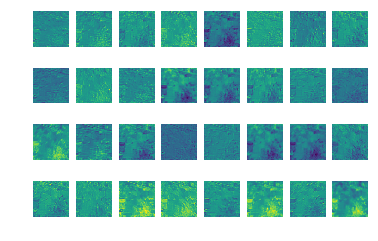

Variable containing:
 0.4547
[torch.FloatTensor of size 1]



In [7]:
reconstruction_error = train_autoencoder(img) # save reconstruction error
activations = get_and_plot_act_map(img) # save activations of the first convolutional layer
print(reconstruction_error)

In [10]:
def get_classification_error(img, y):
    """Gets dataset, splits it to the training and validation set, 
    fits LogisticRegression(ANN) and returns misclassified pixels percentage.
    
    Parameters
    ----------
    img: torch.autograd.Variable
        Dataset.
    y: numpy.ndarray
        Ground truth labels of the given dataset.
        
    Returns
    -------
    error: float
        Misclassification of pixels percentage.
    """
    encoder.training = False
    features_raw = encoder(img) # get encoder output
    features_raw = features_raw.data.numpy() # and conert it to the numpy
    
    # flatten and split to the training and validation parts to fit LogisticRegression(ANN) on this data
    N, C, H, W = features_raw.shape
    features = features_raw.reshape(N, C, -1)
    features = np.transpose(features, (0, 2, 1))
    y = y.reshape(N, -1)

    features_train, features_valid, y_train, y_valid = train_test_split(features, y, test_size=0.3)

    features_train = features_train.reshape(-1, 8)
    y_train = y_train.reshape(-1)
    features_valid = features_valid.reshape(-1, 8)
    y_valid = y_valid.reshape(-1)
    
    # fitting it
    logreg = LogisticRegression()
    logreg.fit(features_train, y_train) # train ANN, with cross entropy loss function
    
    # and predicting the values and getting misclassification percentage
    error = 1 - accuracy_score(y_valid, logreg.predict(features_valid))
    return error

In [11]:
error = get_classification_error(img, y)
print(error)

0.4875196195005945


# Salinas-A

Now let's fine-tune autoencoder and classifier to check their performance on the Salinas-A dataset.

In [12]:
X, y = load_data('data/SalinasA_corrected.mat', 'data/SalinasA_gt.mat', 'salinasA_corrected', 'salinasA_gt')
img = Variable(torch.FloatTensor(X.copy()))

0 1790
1 391
10 1343
11 616
12 1525
13 674
14 799


0.42316866
0.41959763
0.39791557


<Figure size 720x720 with 0 Axes>

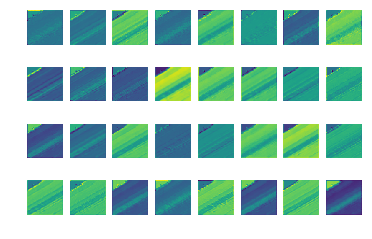

Variable containing:
 0.3795
[torch.FloatTensor of size 1]



In [13]:
reconstruction_error = train_autoencoder(img, epochs=3)
activations = get_and_plot_act_map(img)
print(reconstruction_error)

In [14]:
error = get_classification_error(img, y)
print(error)

0.7332789522681875


# Compare
Unless Activation map and Loss is seem to look better we got worse Classification results on the Salinas-A dataset comparing to Indiana Pines dataset. It may be caused by less training or scene type.